## Challenge: make your own regression model

[Download the Excel file here](https://ucr.fbi.gov/crime-in-the-u.s/2013/crime-in-the-u.s.-2013/tables/table-8/table-8-state-cuts/table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls) on crime data in New York State in 2013, provided by the FBI: UCR ([Thinkful mirror](https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/master/New_York_offenses/NEW_YORK-Offenses_Known_to_Law_Enforcement_by_City_2013%20-%2013tbl8ny.csv)).

Prepare this data to model with multivariable regression (including data cleaning if necessary) according to this specification:

$$ Property crime = \alpha + Population + Population^2 + Murder + Robbery$$



> Using this data, build a regression model to predict property crimes. You can use the features you prepared in the previous assignment, new features of your own choosing, or a combination. The goal here is prediction rather than understanding mechanisms, so the focus is on creating a model that explains a lot of variance.

Submit a notebook with your model and a brief writeup of your feature engineering and selection process to submit and review with your mentor.

In [220]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn import linear_model

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.

import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

In [258]:
link = 'https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/master/New_York_offenses/NEW_YORK-Offenses_Known_to_Law_Enforcement_by_City_2013%20-%2013tbl8ny.csv'

indices_to_skip = np.array([0,1,2,353,354,355])

df = pd.read_csv(link,skiprows=indices_to_skip , header=1)

df.tail()


,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3
343,Woodbury Town,"10,685",3,0,nan,0,2,1,541,9,529,3,nan
344,Woodridge Village,829,7,0,nan,0,0,7,17,8,9,0,0.000
345,Woodstock Town,"5,931",2,0,nan,0,0,2,58,13,45,0,nan
346,Yonkers,"199,134","1,036",6,nan,25,390,615,"2,368",470,"1,662",236,10.000
347,Yorktown Town,"36,643",15,0,nan,0,2,13,334,45,287,2,nan


In [222]:
df.shape

(348, 13)

In [223]:
df.dtypes

City                                       object
Population                                 object
Violent\ncrime                             object
Murder and\nnonnegligent\nmanslaughter      int64
Rape\n(revised\ndefinition)1              float64
Rape\n(legacy\ndefinition)2                object
Robbery                                    object
Aggravated\nassault                        object
Property\ncrime                            object
Burglary                                   object
Larceny-\ntheft                            object
Motor\nvehicle\ntheft                      object
Arson3                                    float64
dtype: object

In [224]:
# Not working:
new_cols = ['Murder','Rubberry']
def insert_cols(df):
    for i in range(len(new_cols)):
        #df[new_cols[i]]==np.nan
        return new_cols[i]
    
insert_cols(df)

'Murder'

In [259]:
cols = df.columns.drop(['City','Murder and\nnonnegligent\nmanslaughter','Rape\n(revised\ndefinition)1','Arson3'])

# Replace ',' before converting to numeric:
df[cols]=df[cols].replace(',*','',regex=True)

# Convert to numeric
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')


In [260]:
# Convert 2 columns to 0 or 1:

# df['Murder'] = np.nan
df.loc[df['Murder and\nnonnegligent\nmanslaughter']>0,'Murder']=1
df.loc[df['Murder and\nnonnegligent\nmanslaughter']==0,'Murder']=0
df.loc[df['Robbery']>0,'Robbery_']=1
df.loc[df['Robbery']==0,'Robbery']=0



In [261]:
# Remove empty initial Murder and Robbery :
df = df.drop('Murder and\nnonnegligent\nmanslaughter',1) # where 1 is the axis number (0 for rows and 1 for columns.)

df = df.drop('Robbery',1) # where 1 is the axis number (0 for rows and 1 for columns.)


In [228]:
# Check if column is string:
if df['Population'].dtype == np.number:
    print('yes')
else:
    print('no number')

no number


In [262]:
# Which are the numeric values from column:
a = pd.to_numeric(df['Population'], errors='coerce')#.isnull()
#type(a)
a.dropna()

0        1861
1        2577
2        2846
3       97956
4        6388
5        4089
6        1781
7      118296
8        9519
9       18182
10       2053
11       4523
12        658
13       2522
14      27270
15       3333
16       7473
17       5418
18      15374
19       5733
20      17627
21      34243
22      46304
23       1410
24      12001
25       1022
26       2325
27       2054
28       2065
29       2358
        ...  
318      3642
319       615
320     12195
321     61686
322     27980
323      6887
324     27940
325      3012
326      3453
327      5828
328      8392
329      5175
330     28179
331     10245
332      1862
333      4337
334     43777
335      1797
336      4574
337      1732
338     44821
339      2604
340     57559
341      3733
342      9141
343     10685
344       829
345      5931
346    199134
347     36643
Name: Population, Length: 348, dtype: int64

In [263]:
df.dtypes

City                             object
Population                        int64
Violent\ncrime                    int64
Rape\n(revised\ndefinition)1    float64
Rape\n(legacy\ndefinition)2       int64
Aggravated\nassault               int64
Property\ncrime                   int64
Burglary                          int64
Larceny-\ntheft                   int64
Motor\nvehicle\ntheft             int64
Arson3                          float64
Murder                          float64
Robbery_                        float64
dtype: object

In [264]:
# Create the column Population ^ 2:
df['population_squared'] = df['Population']**2 

In [232]:
df

,City,Population,Violent crime,Rape (revised definition)1,Rape (legacy definition)2,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3,Murder,Robbery_,population_squared
0,Adams Village,1861,0,nan,0,0,12,2,10,0,0.000,0.000,nan,3463321
1,Addison Town and Village,2577,3,nan,0,3,24,3,20,1,0.000,0.000,nan,6640929
2,Akron Village,2846,3,nan,0,3,16,1,15,0,0.000,0.000,nan,8099716
3,Albany,97956,791,nan,30,526,4090,705,3243,142,nan,1.000,1.000,9595377936
4,Albion Village,6388,23,nan,3,16,223,53,165,5,nan,0.000,1.000,40806544
5,Alfred Village,4089,5,nan,0,2,46,10,36,0,nan,0.000,1.000,16719921
6,Allegany Village,1781,3,nan,0,3,10,0,10,0,0.000,0.000,nan,3171961
7,Amherst Town,118296,107,nan,7,68,2118,204,1882,32,3.000,1.000,1.000,13993943616
8,Amityville Village,9519,9,nan,2,3,210,16,188,6,1.000,0.000,1.000,90611361
9,Amsterdam,18182,30,nan,0,18,405,99,291,15,0.000,0.000,1.000,330585124


In [265]:
df.describe()

,Population,Violent crime,Rape (revised definition)1,Rape (legacy definition)2,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3,Murder,Robbery_,population_squared
count,348.000,348.000,0.000,348.000,348.000,348.000,348.000,348.000,348.000,187.000,348.000,209.000,348.000
mean,40037.632,201.595,nan,5.865,121.261,792.606,119.684,637.017,35.905,1.872,0.141,1.000,203554650960.236
std,450037.368,2815.269,nan,60.425,1706.132,7659.725,924.949,6346.054,403.424,10.693,0.348,0.000,3778875542708.130
min,526.000,0.000,nan,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,276676.000
25%,3003.000,2.000,nan,0.000,1.000,40.500,6.000,31.000,0.000,0.000,0.000,1.000,9018117.000
50%,7233.500,6.000,nan,0.000,4.000,112.500,17.500,94.000,2.000,0.000,0.000,1.000,52325684.500
75%,18427.500,22.000,nan,2.000,14.000,341.000,51.250,287.250,7.000,1.000,0.000,1.000,339753567.000
max,8396126.000,52384.000,nan,1112.000,31767.000,141971.000,16606.000,117931.000,7434.000,132.000,1.000,1.000,70494931807876.000


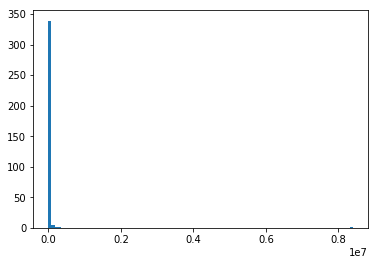

In [266]:
plt.hist(df['Population'],bins=100)
plt.show()

In [267]:
df.sort_values('Population', ascending=False)

,City,Population,Violent crime,Rape (revised definition)1,Rape (legacy definition)2,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3,Murder,Robbery_,population_squared
216,New York,8396126,52384,nan,1112,31767,141971,16606,117931,7434,nan,1.000,1.000,70494931807876
35,Buffalo,258789,3249,nan,145,1735,12491,3458,8076,957,nan,1.000,1.000,66971746521
272,Rochester,210562,2107,nan,92,1055,10051,2587,6855,609,132.000,1.000,1.000,44336355844
346,Yonkers,199134,1036,nan,25,615,2368,470,1662,236,10.000,1.000,1.000,39654349956
310,Syracuse,143834,1192,nan,75,696,6473,1781,4298,394,57.000,1.000,1.000,20688219556
7,Amherst Town,118296,107,nan,7,68,2118,204,1882,32,3.000,1.000,1.000,13993943616
3,Albany,97956,791,nan,30,526,4090,705,3243,142,nan,1.000,1.000,9595377936
126,Greece Town,96667,151,nan,9,82,2303,332,1925,46,nan,0.000,1.000,9344508889
267,Ramapo Town,87204,57,nan,5,41,567,88,466,13,nan,1.000,1.000,7604537616
57,Clarkstown Town,80705,65,nan,8,40,1515,99,1388,28,nan,0.000,1.000,6513297025


In [268]:
val_cols = df.columns.drop(['City'])
val_cols

Index(['Population', 'Violent\ncrime', 'Rape\n(revised\ndefinition)1',
       'Rape\n(legacy\ndefinition)2', 'Aggravated\nassault', 'Property\ncrime',
       'Burglary', 'Larceny-\ntheft', 'Motor\nvehicle\ntheft', 'Arson3',
       'Murder', 'Robbery_', 'population_squared'],
      dtype='object')

In [269]:
# Drop values that are outliers (more than 3 stdev from the mean):
q = df["Population"].quantile(0.99)
df=df[df["Population"] < q].sort_values('Population', ascending=False)#.head(10)

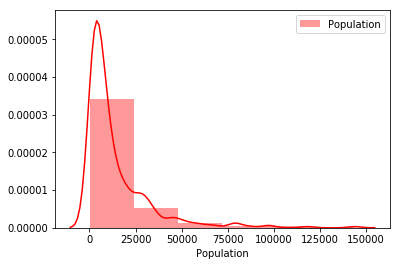

In [271]:
import seaborn as sns

sns.distplot( df["Population"] , color="red", label="Population",bins=6)
plt.legend()
plt.show()

In [ ]:
for col_id in val_cols:
    sns.distplot(df[col_id].dropna())

In [ ]:
sns.distplot(df['Arson3'].dropna())

------------------

-------------

In [272]:
# Which are the numeric values from this column to know if to drop or to fillna:
a = pd.to_numeric(df['Arson3'], errors='coerce')#.isnull()
#type(a)
a.dropna()

310   57.000
7      3.000
53     2.000
62    10.000
314    1.000
140    2.000
301    1.000
315    5.000
218   22.000
134    6.000
338    0.000
108    8.000
139    3.000
167    0.000
45     1.000
271    0.000
274    2.000
210    2.000
237    0.000
257    0.000
276    4.000
209   15.000
324    1.000
195    4.000
117    0.000
205    0.000
215    4.000
239    0.000
187    0.000
39     1.000
       ...  
106    0.000
186    0.000
75     0.000
208    0.000
258    0.000
128    0.000
295    0.000
242    0.000
149    1.000
23     0.000
238    0.000
293    0.000
157    0.000
256    0.000
200    0.000
34     0.000
77     0.000
87     0.000
227    0.000
25     0.000
260    0.000
48     0.000
266    0.000
287    0.000
344    0.000
44     0.000
12     0.000
136    0.000
319    0.000
118    0.000
Name: Arson3, Length: 185, dtype: float64

In [273]:
# Remove empty column :
df = df.drop('Rape\n(revised\ndefinition)1',1) # where 1 is the axis number (0 for rows and 1 for columns.)


In [274]:
df.shape

(344, 13)

In [275]:
# Fill column 'Arson3' with ZEROs where 'nan':
df['Arson3'].fillna(0 , inplace = True)
df['Robbery_'].fillna(0 , inplace = True)

In [276]:
# Check which columns have one or more 'nan' that prevend the algorithm from working?:
df[df.isnull().any(axis=1)]

,City,Population,Violent crime,Rape (legacy definition)2,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3,Murder,Robbery_,population_squared


In [277]:
X_cols = df.columns.drop(['City','Property\ncrime'
                          ,'Murder', 'Robbery_', 'population_squared'
                         ])
X_cols

Index(['Population', 'Violent\ncrime', 'Rape\n(legacy\ndefinition)2',
       'Aggravated\nassault', 'Burglary', 'Larceny-\ntheft',
       'Motor\nvehicle\ntheft', 'Arson3'],
      dtype='object')

In [278]:
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = df['Property\ncrime'].values.reshape(-1, 1)
X = df[X_cols]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [[ 7.96710166e-18 -8.95900022e-16 -8.23535881e-15  3.56112302e-15
   1.00000000e+00  1.00000000e+00  1.00000000e+00 -2.01230932e-14]]

Intercept: 
 [-1.13686838e-13]

R-squared:
1.0


<i>Finally, and probably of greatest interest, we get an <b>R-Squared</b> value. This is a proportion (between 0 and 1) that expresses <b>how much <u>VARIANCE</u> in the outcome variable our model was able to explain</b>. 

Higher  <b>R2</b>  values are better to a point-- a low  <b>R2</b>  indicates that our model isn't explaining much information about the outcome, which means it will not give very good predictions. 
    
However, a very high  <b>R2</b>  is a warning sign for overfitting. 

No dataset is a perfect representation of reality, so a model that perfectly fits our data ( <b>R2</b>  of 1 or close to 1) is likely to be biased by quirks in the data, and will perform less well on the test-set.</i>

Assumptions of Multivariable Linear Regression
For regression to work its magic, inputs to the model need to be consistent with four assumptions:

1. Assumption one: linear relationship
2. Assumption two: multivariate normality
3. Assumption three: homoscedasticity
4. Assumption four: low multicollinearity


### 1. Assumption one: linear relationship

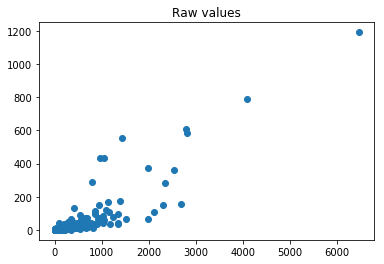

In [279]:
# Plot the data as-is.
#plt.scatter(outcome, feature)
plt.scatter(df['Property\ncrime'], df['Violent\ncrime'])

plt.title('Raw values')
plt.show()

In [280]:
scatter_cols = df.columns.drop(['City','Property\ncrime'
                          ,'Population' # we already removed outliers
                          ,'Murder', 'Robbery_', 'population_squared' # categorical and quadratic
                         ])
scatter_cols

Index(['Violent\ncrime', 'Rape\n(legacy\ndefinition)2', 'Aggravated\nassault',
       'Burglary', 'Larceny-\ntheft', 'Motor\nvehicle\ntheft', 'Arson3'],
      dtype='object')

In [281]:
# Drop rows that are outliers (more than 3 stdev from the mean):

for i in scatter_cols:
    q = df[i].quantile(0.99)
    df=df[df[i] < q].sort_values(i, ascending=False)#.head(10)

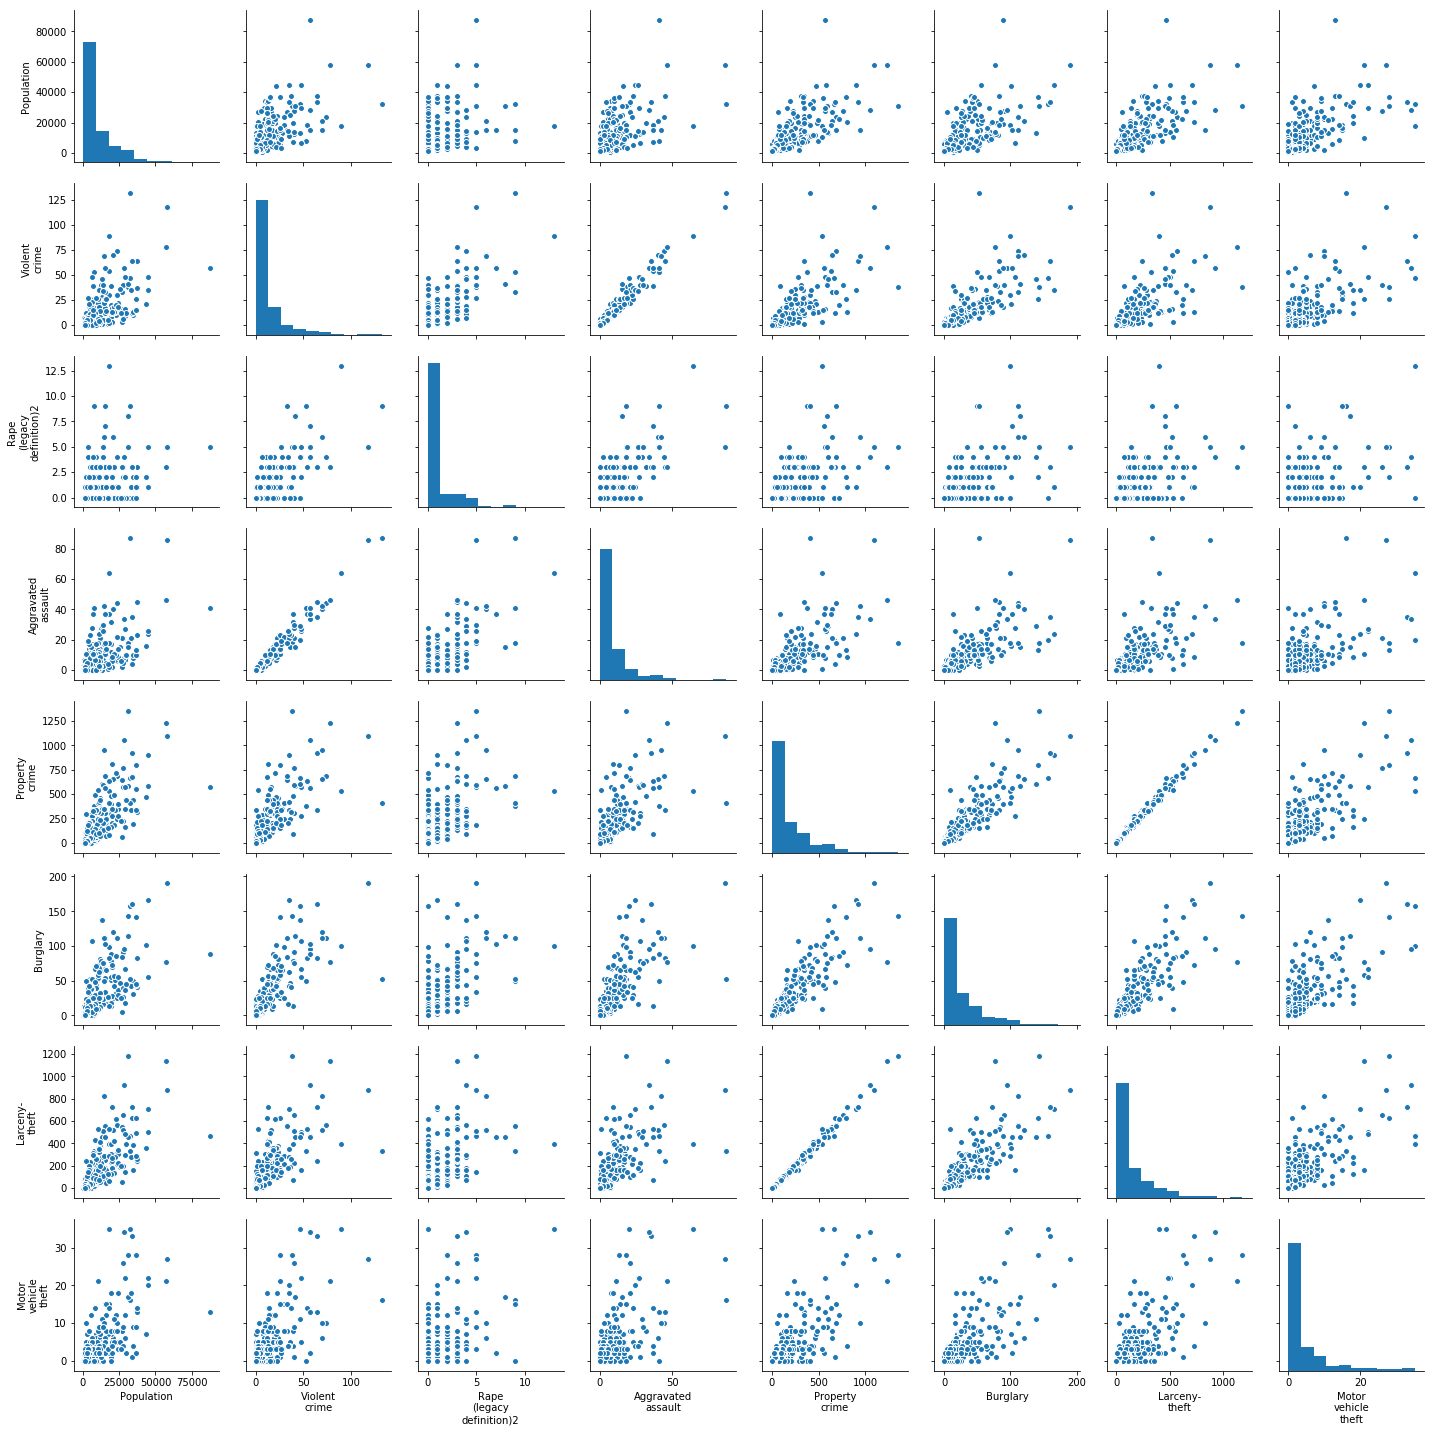

In [286]:
# Create the default pairplot
df2 = df.drop(['Murder', 'Robbery_', 'population_squared','Arson3'],1) # where 1 is the axis number (0 for rows and 1 for columns.)
sns.pairplot(df2)
plt.show()

In [ ]:
X_cols